<a href="https://colab.research.google.com/github/souchem23/data-science-coursework/blob/main/Unit5/Soumik_ChemudupatiU5ProjFINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<center>Predicting Harmonics-to-noise ratio (HNR) based on Dopmamine Concentration (D2) Presence for Parkinson's Patients**

##<center> Question: Predicting D2 (Dopamine) Concentration (x-axis) vs. Harmonics-to-noise ratio (y-axis)

### <center>Report by Soumik Chemudupati

#**PART I: Introduction**

##**Context**

Parkinson's Disesase is a neurodegenerative disease that tends to affect motor actions and skills of patients with the disease. Here are a few definitions to provide a bit of context surrounding this report.

**Harmonics-to-noise (HNR) ratio:**
*   This ratio refers to the value relating the clear, reoccuring components of voice and the irregular components of voice.
*   It refers to the balance between correctly functioning and incorrectly functioning componentes of voice. Lower is better and indicates less severe Parkinson's.

**Dopamine Concentration (D2):**
*   Refers to a D2 receptor that plays a crucial role in the brain's central motor control system.

In this project, I am investigating the association between the HNR ratio and the D2 concentration, so that we can measure how an indivdual's brain is being affected by simply looking at their voice. How does D2 concentration (x-axis) affect Harmonics-to-noise ratio (y-axis)?




##**Significance**

In our modern society, there is a dire need to predict Parkinson's disease in early-stage patients by analyzing behavioralistic tendencies. Blood tests and MRI scans are an OK solution, but cannot be easily extended to a large scale.

Making these assocations between behavioral tendencies from an easily measurable horomone will allow doctors to gain a signifcant insight into future patterns of Parkinson's patients, saving their lives.

##**Preparation**

###Package Installation

In [1]:
# Installing packages
!pip install preliz
import preliz as pz

import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr

from scipy.interpolate import PchipInterpolator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 43.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


###Dataset Preparation

In [2]:
# Reading in the data
parkinsonDataURL = 'https://raw.githubusercontent.com/souchem23/data-science-coursework/refs/heads/main/parkinsonsDataFeatures.csv'

# Creating dataframe representation
parkinsonData = pd.read_csv(parkinsonDataURL)

parkinsonData = parkinsonData[['HNR', 'D2']]

# Display processed data
parkinsonData

,HNR,D2
0,21.033,2.301442
1,19.085,2.486855
2,20.651,2.342259
3,20.644,2.405554
4,19.649,2.332180
...,...,...
190,19.517,2.657476
191,19.147,2.784312
192,17.883,2.679772
193,19.020,2.138608


Text(0, 0.5, 'Harmonics-to-noise Ratio')

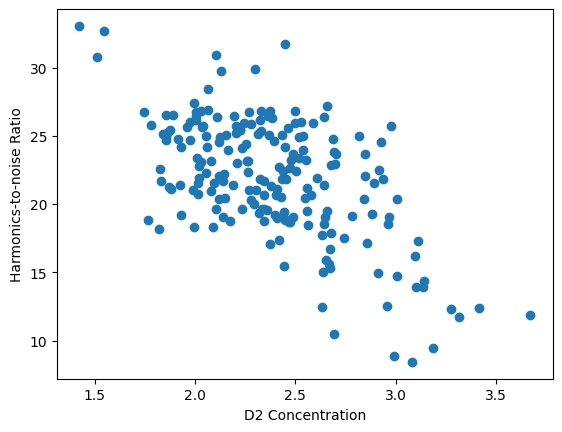

In [29]:
plt.scatter(parkinsonData['D2'], parkinsonData['HNR'])

#label axes
plt.xlabel("D2 Concentration")
plt.ylabel("Harmonics-to-noise Ratio")

Simply, taking a look at the trend, we can see a general downward trend between our independent and dependent variable. Let's start with our first linear model.

#**PART 2: MODELS**

##**Model 1**

In [112]:
with pm.Model() as model_lb:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * parkinsonData.HNR)

    #prior for the standard deviation of our likelihood
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=parkinsonData.D2)

    #inference data object
    idata_lb = pm.sample()

Output()

Output()

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

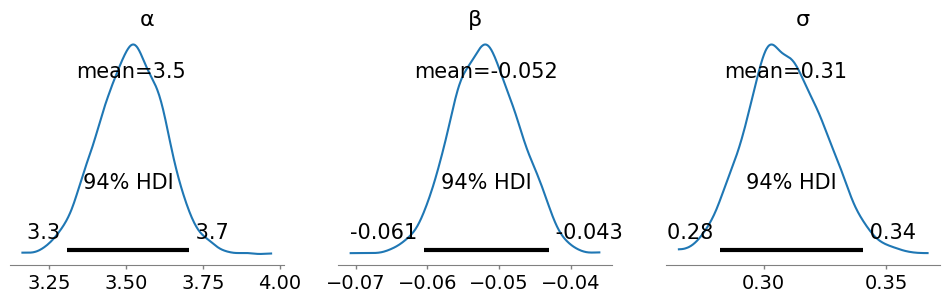

In [113]:
az.plot_posterior(idata_lb, var_names=["~μ"], figsize=(12, 3))
pm.sample_posterior_predictive(idata_lb, model=model_lb,  extend_inferencedata=True)

Text(0, 0.5, 'HNR Ratio')

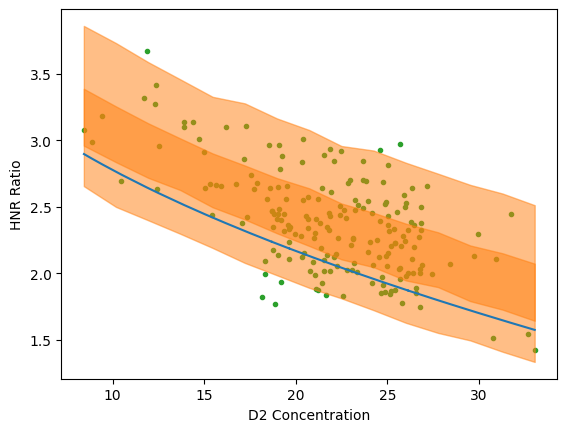

In [27]:
#grabs the expected line, or line of best fit formula
mean_line = idata_lb.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
threads = np.random.normal(parkinsonData.HNR.values, 0.01)
idx = np.argsort(threads)
x = np.linspace(threads.min(), threads.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_lb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(threads[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(parkinsonData.HNR, parkinsonData.D2, "C2.", zorder=-3)
ax.plot(parkinsonData.HNR[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("D2 Concentration")
ax.set_ylabel("HNR Ratio")

<Axes: xlabel='y_pred'>

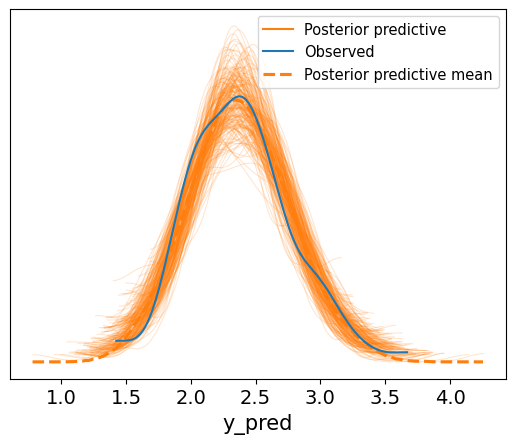

In [115]:
az.plot_ppc(idata_lb, num_pp_samples=200, colors=["C1", "C0", "C1"])

###**Analysis:**

This model is quite good. Taking a look at the first graph, we can see that our linear model matches the negative trend that we had anticipated. It generally goes through the middle of the data, and has a negative slope.

Looking at the PPC, we can see that our posterior predictive is actually very solid! the  mean matches almost exactly with the actual observed data. However, the observed data is very close to the edge of the posterior predictive mean, so the tails are still misaligned. Let's see if we can fix that.

##**Wait! Square Root Function?**

I am NOW switching to use a square root function in my regression. Here is why.

Here are my initial thoughts:

Usually, small changes in dopamine levels tend to correlate to higher changes in motor control such as jittering. So, I am making the assumption that a smaller amount of Dopamine concetration will leader to a larger change in the Harmonics-to-noise ratio (behavioral change). It seems to have a sort of "diminishing return" behavior just looking at how hormones affect other behavioralistic tendencies like jittering.

Also, I think that there might be a point where reducing dopamine concentration over a certain amount will have a less noticeable impact on HNR ratio since other neurological processes like neuron chnages may affect the HNR ratio. I am not too aware of this point, but I have read in some studies that there is a point at which the HNR ratio plateaus, and this behavior is best modeled by a square root function.

But, WAIT!!

However, it is important to understand that with the square root curve I have chosen to resemble this process, it will continue to go on forever as the D2 concentration increases. Obviously, in the real world, this trend would not conitnue on and on forever. **So, for the purposes of curve fitting, I am putting the real world aside in order to try and find a curve that fits the data the best.**

##**Model 2**

In [119]:
with pm.Model() as model_lb:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + -β * pm.math.sqrt(parkinsonData.HNR))

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfNormal("σ", sigma=100)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=parkinsonData.D2)

    #inference data object
    idata_lb = pm.sample()

Output()

Output()

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

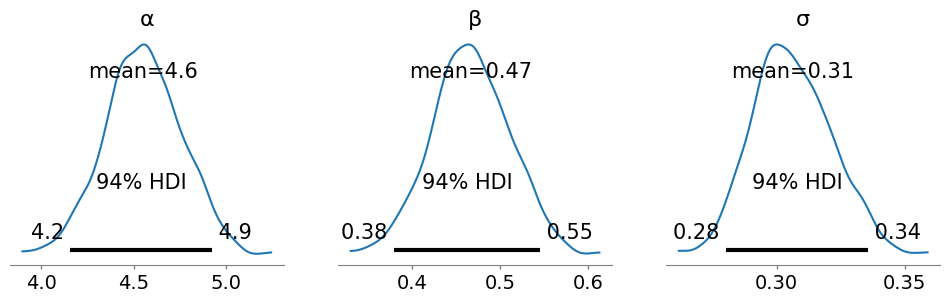

In [120]:
az.plot_posterior(idata_lb, var_names=["~μ"], figsize=(12, 3))
pm.sample_posterior_predictive(idata_lb, model=model_lb,  extend_inferencedata=True)

Text(0, 0.5, 'HNR Ratio')

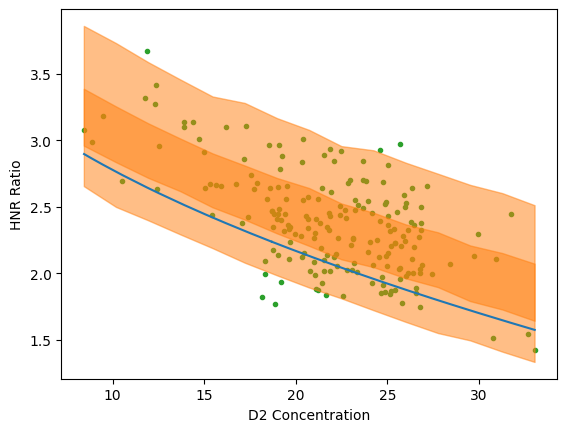

In [26]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_lb.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
threads = np.random.normal(parkinsonData.HNR.values, 0.01)
idx = np.argsort(threads)
x = np.linspace(threads.min(), threads.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_lb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(threads[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(parkinsonData.HNR, parkinsonData.D2, "C2.", zorder=-3)
ax.plot(parkinsonData.HNR[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("D2 Concentration")
ax.set_ylabel("HNR Ratio")

<Axes: xlabel='y_pred'>

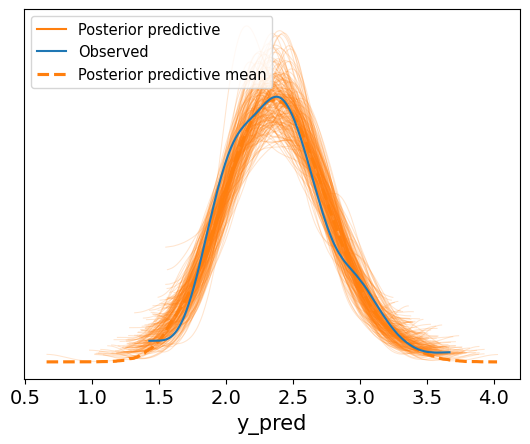

In [122]:
az.plot_ppc(idata_lb, num_pp_samples=200, colors=["C1", "C0", "C1"])

###**Analysis:**

This model is also good. I have chosen to use a generalzed linear and implemented a square root function for my x values. I have used this in my deterministic model, and we can see that this model also performs well.

Looking at the graph, we can see the general downward trend, now informed by a curved pattern. I feel that this mdoel actually does a better job than the previous model as it captures the trend that as the HNR ratio the D2 concetration starts to decrase, but not by as much.

Looking at the PPC, we can get similar results to our last model. The means match extremely closely, but for the tails, they lie on the edge of the posterior predictive mean. Let's see if we can fix this!

##**Model 3**

In [20]:
with pm.Model() as model_lb:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + -β * pm.math.sqrt(parkinsonData.HNR))

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfNormal("σ", sigma=10)

    alpha = pm.Normal("alpha", mu=3, sigma = 1)

    #likelihood
    y_pred = pm.SkewNormal("y_pred", mu=μ, sigma=σ,alpha = alpha, observed=parkinsonData.D2)

    #inference data object
    idata_lb = pm.sample()

Output()

Output()

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

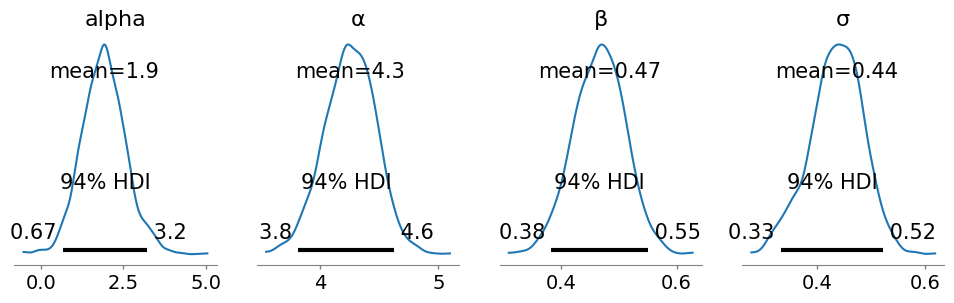

In [21]:
az.plot_posterior(idata_lb, var_names=["~μ"], figsize=(12, 3))
pm.sample_posterior_predictive(idata_lb, model=model_lb,  extend_inferencedata=True)

Text(0, 0.5, 'HNR Ratio')

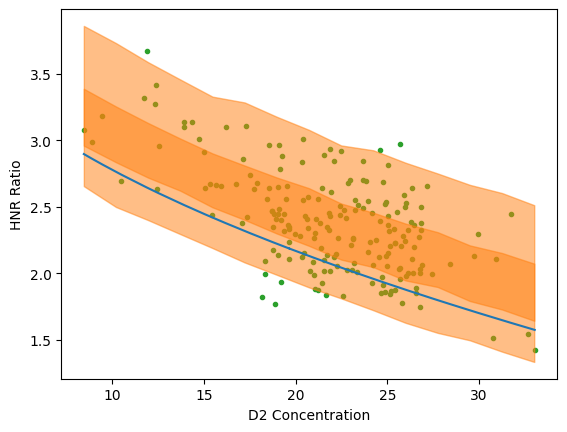

In [28]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_lb.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
threads = np.random.normal(parkinsonData.HNR.values, 0.01)
idx = np.argsort(threads)
x = np.linspace(threads.min(), threads.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_lb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(threads[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(parkinsonData.HNR, parkinsonData.D2, "C2.", zorder=-3)
ax.plot(parkinsonData.HNR[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("D2 Concentration")
ax.set_ylabel("HNR Ratio")

<Axes: xlabel='y_pred'>

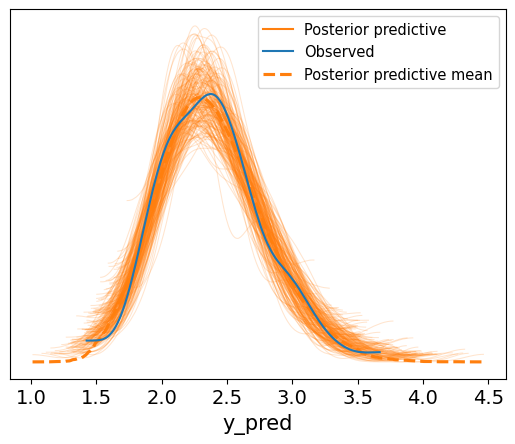

In [23]:
az.plot_ppc(idata_lb, num_pp_samples=200, colors=["C1", "C0", "C1"])

###**Analysis:**

This model is going to be our best! Taking a look at the graph, we can see that the predicted line is a bit lower. We  still have a downward curve acheived with the square root function in the regression. Compared to the rest of the models, the created line looks a lot lower than the previously created models.

Turning to the posterior predictive check, this model looks a lot better. The mean of the observed data and the posterior predictive mean match very well. Additioanlly, the tails are more in the center of the posterior predictive mean, and the rest of the graph is also contained very well inside the PPC mean. This shows us that the skew is a lot better for this mean.

#**PART 3: Final Analysis**

Looking at the PCC, we can see that our final model has a distribution that is extremely close to the PPC.

It was interesting to see that as the D2 Concentration increased, there was NOT a direct linear relationship with the Harmonics-to-noise ratio. Rather, as the D2 concentration increses, the rate at which the Harmonics-to-noise ratio decreases slows donwn (diminishing returns curvature). These properties seems to resemble a square root curve that I implemented in my final model. Based on my prior knowledge, I always thought that D2 and the Harmonics-to-noise ratio would have a straight-line relationship.

The fact that there is NOT a direct correlation proves to me that there may be another factor that affects this Harmonics-to-noise ratio more significantly. Specifically, additional behavioral tendencies like jittering and the folding of vocal chords tends to play a significant role in the the HNR ratio.

Based on my prior knowledge, our brain usually tends to affect our actions. Specifically, emotions formed in the amygdala region affect our Gangal Baslia, which inform our actions and motor functions. Thus, I think that there is a more intricate process that I am not understanding fully. Although D2 concetration indicates the presense of a hormone, it likely affects other parts of the brain such as the Amgydala, that then affect our motor control and voice control. This is a very interesting medical find and I have not found many studies which show this correlation, so it is still a bit fuzzy.

It also gives a bit of insight into the point at which D2 concentration does not affect HNR ratio as much. The square root curve aligns with my predictions that at some point, changes in D2 don't affect the HNR ratio as much.
